In [ ]:
# Clonar el repositorio con los datos
!git clone https://github.com/danilo0327/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data.git

# Verificar las carpetas
!ls COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data


fatal: destination path 'COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data' already exists and is not an empty directory.
dataframe  raw	xray_images.csv.dvc


In [ ]:
#Librerias
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader






In [ ]:
# Ruta al dataset
DATASET_DIR = "/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data"

# Revisar estructura
for root, dirs, files in os.walk(DATASET_DIR):
    print(root, len(files))


/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data 2
/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw 0
/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw/Lung_Opacity 0
/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw/Lung_Opacity/images 100
/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw/COVID 0
/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw/COVID/images 100
/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw/Normal 0
/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw/Normal/images 100
/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw/Viral Pneumonia 0
/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw/Viral Pneumonia/images 100
/con

In [ ]:
# Ruta base
DATASET_DIR = "/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw"

# Generador de imágenes con augmentación
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # 80% train, 20% validation
)

# Generador de entrenamiento
train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(224,224),  # tamaño para red preentrenada
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

# Generador de validación
val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

# Ver clases detectadas
print(train_gen.class_indices)

Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


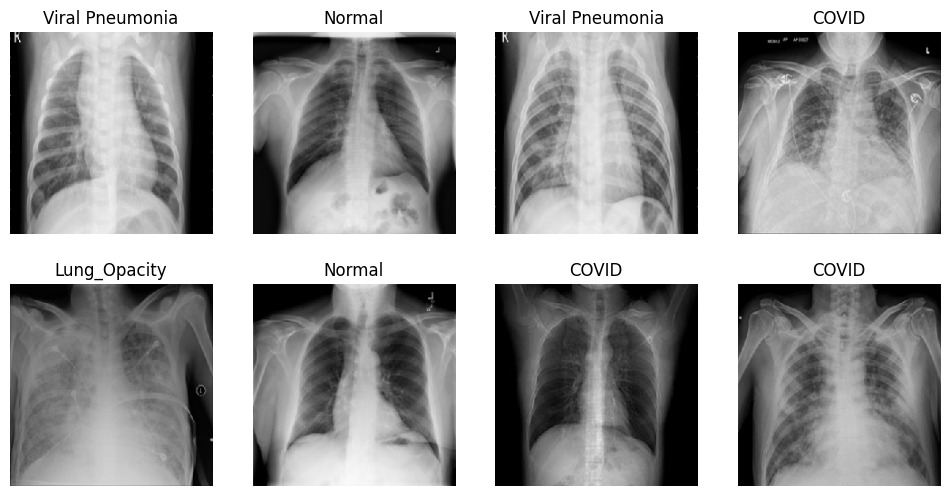

In [ ]:
# Obtener un batch de imágenes y etiquetas
images, labels = next(train_gen)

# Mostrar primeras 8 imágenes
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.title(list(train_gen.class_indices.keys())[np.argmax(labels[i])])
    plt.axis("off")

plt.show()

#Entrenando un modelo sencillo #

Primero se quiere validar que el pipeline de los datos, entrenamiento y evaluacipon funcionan

In [ ]:
# Definir modelo CNN con Flatten
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 clases
])

# Compilar modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo


In [ ]:
# Entrenar modelo
history_CNN = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - accuracy: 0.2996 - loss: 5.7043 - val_accuracy: 0.4000 - val_loss: 1.3286
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4901 - loss: 1.2071 - val_accuracy: 0.5500 - val_loss: 1.0713
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.6230 - loss: 0.8861 - val_accuracy: 0.5500 - val_loss: 1.0650
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.7322 - loss: 0.7101 - val_accuracy: 0.5750 - val_loss: 1.0024
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7693 - loss: 0.5656 - val_accuracy: 0.5500 - val_loss: 1.0286
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8343 - loss: 0.4356 - val_accuracy: 0.5500 - val_loss: 1.0435
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8510 - loss: 0.4005 - val_accuracy: 0.5875 - val_loss: 1.1431
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.8803 - loss: 0.3587 - val_accuracy: 0.6125 - val

Curvas de entrenamiento

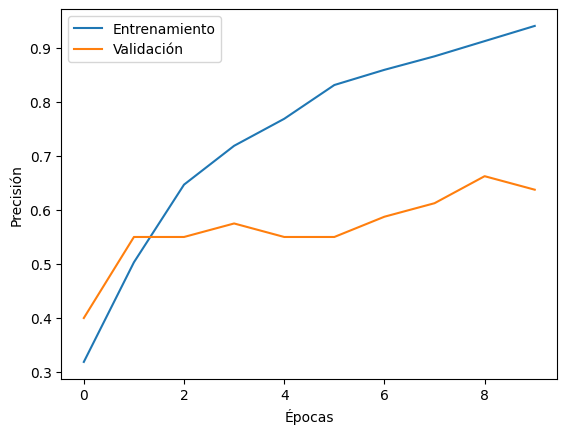

In [ ]:
plt.plot(history_CNN.history['accuracy'], label='Entrenamiento')
plt.plot(history_CNN.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Analisis: Overfitting, aparentemente el modelo es demasiado grande para el dataset pequeño

## CNN simplificada

In [ ]:
# CNN simplificada
model_simplified = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),   # Reduce drásticamente parámetros
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')   # 4 clases
])

# Compilación
model_simplified.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Entrenamiento
history_simplified = model_simplified.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.2295 - loss: 1.3936 - val_accuracy: 0.2500 - val_loss: 1.3858
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.2903 - loss: 1.3851 - val_accuracy: 0.2500 - val_loss: 1.3856
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.2588 - loss: 1.3882 - val_accuracy: 0.3250 - val_loss: 1.3853
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.2649 - loss: 1.3836 - val_accuracy: 0.2500 - val_loss: 1.3849
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.2587 - loss: 1.3855 - val_accuracy: 0.3000 - val_loss: 1.3832
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.2614 - loss: 1.3835 - val_accuracy: 0.3375 - val_loss: 1.3788
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.2734 - loss: 1.3877 - val_accuracy: 0.3625 - val_loss: 1.3790
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.3402 - loss: 1.3741 - val_accuracy: 0.

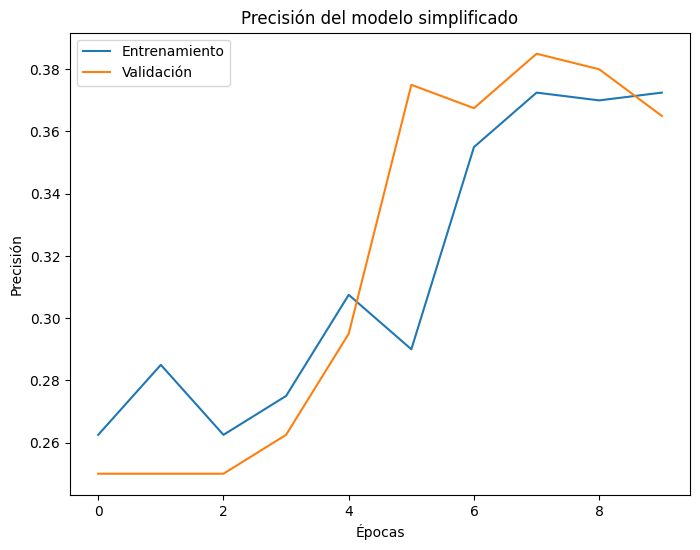

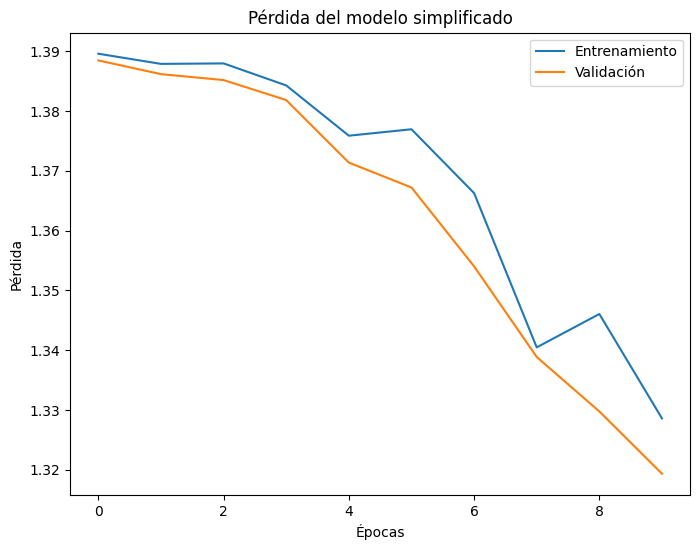

In [ ]:
# Accuaracy
plt.figure(figsize=(8,6))
plt.plot(history_simplified.history['accuracy'], label='Entrenamiento')
plt.plot(history_simplified.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo simplificado')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# loss
plt.figure(figsize=(8,6))
plt.plot(history_simplified.history['loss'], label='Entrenamiento')
plt.plot(history_simplified.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo simplificado')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Con 100 imágenes por clase, entrenar una CNN desde cero no es suficiente.
Necesitamos transfer learning (usar un modelo preentrenado en ImageNet) para aprovechar representaciones ya aprendidas.

### ResNet50

Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    '/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset=None,
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    '/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


Modelo ResNet50

In [ ]:
# Cargar ResNet50 preentrenada sin la parte superior (clasificador final)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Congelar capas convolucionales (no entrenables al inicio)
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuestro clasificador
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=output)

# Compilar
model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Entrenamiento

In [ ]:
history_resnet = model_resnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2213 - loss: 1.6093 - val_accuracy: 0.2575 - val_loss: 1.3801
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 487ms/step - accuracy: 0.2384 - loss: 1.5386 - val_accuracy: 0.2500 - val_loss: 1.3831
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 578ms/step - accuracy: 0.2060 - loss: 1.5380 - val_accuracy: 0.2600 - val_loss: 1.3765
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 488ms/step - accuracy: 0.2887 - loss: 1.4447 - val_accuracy: 0.2550 - val_loss: 1.3752
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 567ms/step - accuracy: 0.2568 - loss: 1.4720 - val_accuracy: 0.4200 - val_loss: 1.3728
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step - accuracy: 0.2802 - loss: 1.4375 - val_accuracy: 0.2700 - val_loss: 1.3713
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 564ms/step - accuracy: 0.2040 - loss: 1.4590 - val_accuracy: 0.3025 - val_loss: 1.3700
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step - accuracy: 0.2190 - loss: 1.4394 - val_accuracy: 0.43

Resultados: Accuaracy y loss


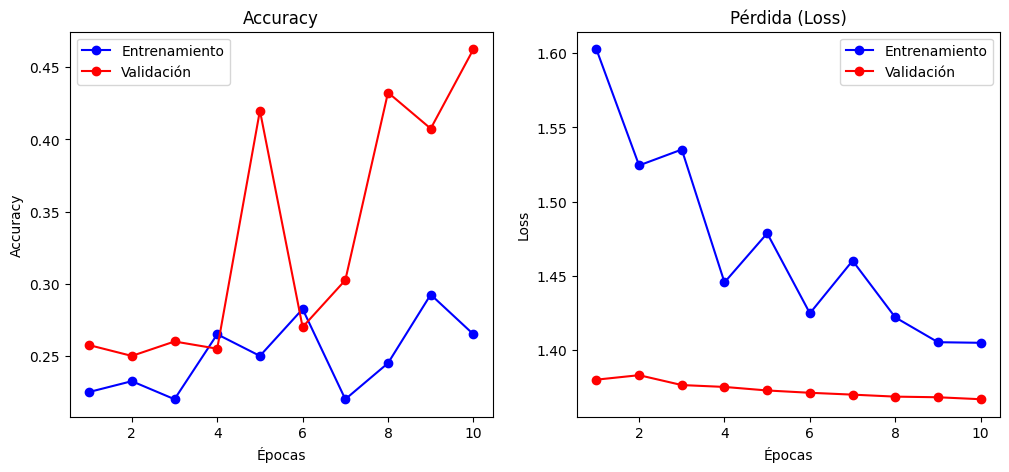

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo-', label='Entrenamiento')
    plt.plot(epochs, val_acc, 'ro-', label='Validación')
    plt.title('Accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo-', label='Entrenamiento')
    plt.plot(epochs, val_loss, 'ro-', label='Validación')
    plt.title('Pérdida (Loss)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_resnet)

In [ ]:
# Obtener etiquetas verdaderas del generador de validación
y_true = val_gen.classes

# Obtener las predicciones del modelo
y_pred_probs = model_resnet.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener los nombres de las clases
class_labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step
                 precision    recall  f1-score   support

          COVID       0.40      0.66      0.49       100
   Lung_Opacity       0.00      0.00      0.00       100
         Normal       0.41      0.31      0.35       100
Viral Pneumonia       0.56      0.88      0.68       100

       accuracy                           0.46       400
      macro avg       0.34      0.46      0.38       400
   weighted avg       0.34      0.46      0.38       400



El modelo puede aprender sin embargo posiblemente no es suficiente los datos para el modelo, si aumentamos la muestra podría aumentar el accuaracy. Podemos intentar con un modelo como ResNet18

ResNet18

In [ ]:
# Transformaciones (data augmentation + normalización como en ImageNet)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

#  Directorios
data_dir = "/content/COVID-19-Patient-Classification-from-Chest-X-rays-Using-Public-Data/data/raw"

image_datasets = {
    'train': datasets.ImageFolder(data_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(data_dir, transform=data_transforms['val'])
}

# DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=16, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=16, shuffle=False)
}

#  Modelo ResNet18 preentrenado
model = models.resnet18(pretrained=True)

# Congelar capas iniciales
for param in model.parameters():
    param.requires_grad = False

# Reemplazar la capa final por 4 clases
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#  Entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

#  Loop de entrenamiento
for epoch in range(10):
    print(f"Epoch {epoch+1}/10")

    # Train
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects.double() / len(image_datasets['train'])
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(image_datasets['val'])
    val_acc = val_corrects.double() / len(image_datasets['val'])
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


Epoch 1/10
Train Loss: 1.3380 Acc: 0.3650
Val Loss: 1.3990 Acc: 0.3675
Epoch 2/10
Train Loss: 1.0802 Acc: 0.5675
Val Loss: 1.1142 Acc: 0.4600
Epoch 3/10
Train Loss: 0.9346 Acc: 0.6450
Val Loss: 0.8086 Acc: 0.7150
Epoch 4/10
Train Loss: 0.8538 Acc: 0.6750
Val Loss: 0.7559 Acc: 0.7350
Epoch 5/10
Train Loss: 0.8001 Acc: 0.7125
Val Loss: 0.7043 Acc: 0.7600
Epoch 6/10
Train Loss: 0.7235 Acc: 0.7300
Val Loss: 0.6912 Acc: 0.7475
Epoch 7/10
Train Loss: 0.7079 Acc: 0.7475
Val Loss: 0.6753 Acc: 0.7675
Epoch 8/10
Train Loss: 0.6609 Acc: 0.7350
Val Loss: 0.6069 Acc: 0.7750
Epoch 9/10
Train Loss: 0.6256 Acc: 0.7875
Val Loss: 0.6884 Acc: 0.7350
Epoch 10/10
Train Loss: 0.7004 Acc: 0.7125
Val Loss: 0.6373 Acc: 0.7300


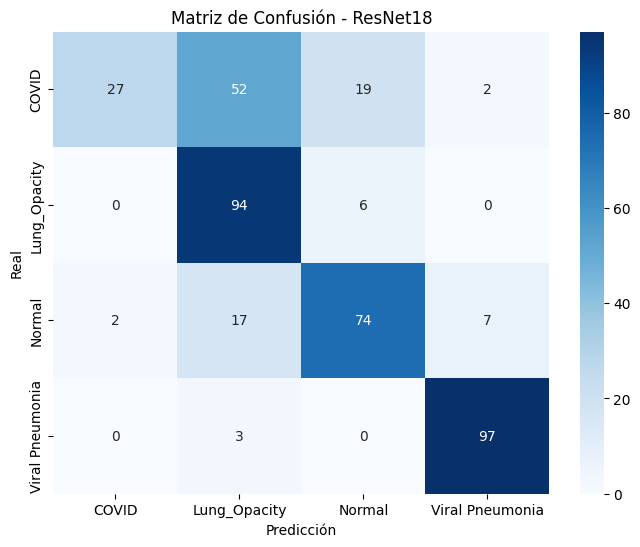

Reporte de clasificación:
                 precision    recall  f1-score   support

          COVID       0.93      0.27      0.42       100
   Lung_Opacity       0.57      0.94      0.71       100
         Normal       0.75      0.74      0.74       100
Viral Pneumonia       0.92      0.97      0.94       100

       accuracy                           0.73       400
      macro avg       0.79      0.73      0.70       400
   weighted avg       0.79      0.73      0.70       400



In [ ]:
#  Evaluación
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Matriz de confusión ---
cm = confusion_matrix(all_labels, all_preds)
class_names = list(image_datasets['val'].classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - ResNet18')
plt.show()

#  Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Analizando los modelos

In [ ]:
plt.figure(figsize=(10,6))

# Graficar accuracy de validación de cada modelo
plt.plot(history.history['val_accuracy'], label='CNN inicial')
plt.plot(history_simplified.history['val_accuracy'], label='CNN simplificada')
plt.plot(history_vgg.history['val_accuracy'], label='Transfer learning (VGG)') # Uncomment if you train a VGG model


plt.title('Comparación de accuracy en validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Modelo preentrenado
resnet18 = models.resnet18(weights="IMAGENET1K_V1")
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 4)  # 4 clases: COVID, Opacidad, Normal, Viral Pneumonia

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=1e-4)

# Variables para guardar métricas
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

num_epochs = 10  # Parámetro a ajustar

for epoch in range(num_epochs):
    resnet18.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloaders['train']:  # train_loader defined before
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloaders['train'])
    train_acc = 100. * correct / total

    # Evaluación
    resnet18.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloaders['val']:  # val_loader defined before
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(dataloaders['val'])
    val_acc = 100. * correct / total

    # Guardar métricas
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/10 - Train Acc: 67.50% | Val Acc: 85.50% Train Loss: 0.8433 | Val Loss: 0.4941
Epoch 2/10 - Train Acc: 88.00% | Val Acc: 93.00% Train Loss: 0.4010 | Val Loss: 0.2256
Epoch 3/10 - Train Acc: 93.00% | Val Acc: 98.00% Train Loss: 0.1887 | Val Loss: 0.0829
Epoch 4/10 - Train Acc: 96.00% | Val Acc: 97.75% Train Loss: 0.1380 | Val Loss: 0.0771
Epoch 5/10 - Train Acc: 93.75% | Val Acc: 99.00% Train Loss: 0.1776 | Val Loss: 0.0565
Epoch 6/10 - Train Acc: 97.50% | Val Acc: 99.25% Train Loss: 0.0917 | Val Loss: 0.0246
Epoch 7/10 - Train Acc: 98.00% | Val Acc: 98.50% Train Loss: 0.0662 | Val Loss: 0.0553
Epoch 8/10 - Train Acc: 98.50% | Val Acc: 99.75% Train Loss: 0.0622 | Val Loss: 0.0135
Epoch 9/10 - Train Acc: 98.75% | Val Acc: 99.50% Train Loss: 0.0497 | Val Loss: 0.0199
Epoch 10/10 - Train Acc: 97.00% | Val Acc: 99.00% Train Loss: 0.0826 | Val Loss: 0.0270


In [ ]:
print(history_CNN.history.keys())
print(history_CNN.history['val_accuracy'])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
[0.4000000059604645, 0.550000011920929, 0.550000011920929, 0.574999988079071, 0.550000011920929, 0.550000011920929, 0.5874999761581421, 0.612500011920929, 0.6625000238418579, 0.637499988079071]


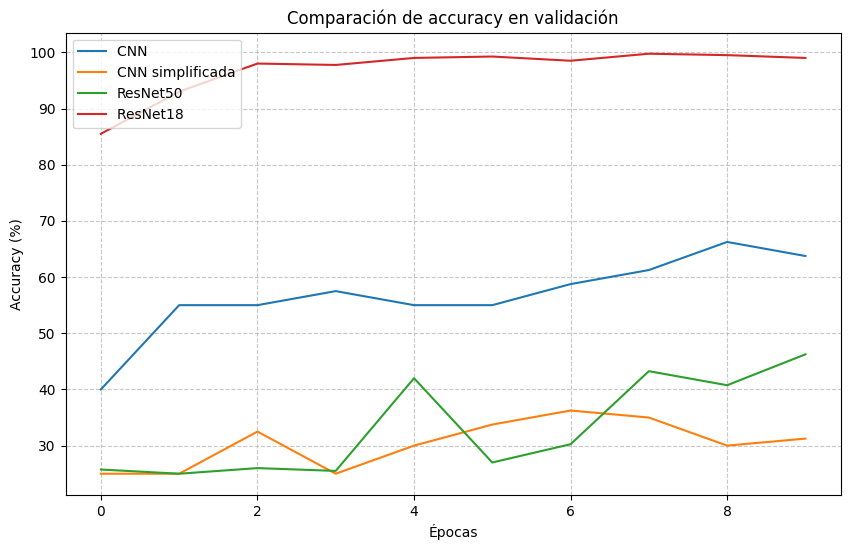

In [ ]:

plt.figure(figsize=(10,6))

# Pasamos todo a porcentaje (%)
plt.plot([a*100 for a in history_CNN.history['val_accuracy']], label='CNN ')
plt.plot([a*100 for a in history_simplified.history['val_accuracy']], label='CNN simplificada')
plt.plot([a*100 for a in history_resnet.history['val_accuracy']], label='ResNet50')
plt.plot(val_acc_history, label='ResNet18 ')


plt.title('Comparación de accuracy en validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()